'''
 *--------------------------------------------------------------------------
 *--------------------------------------------------------------------------
 *
 * Copyright (C) 2017 Kareem Abdelfatah - krabea@email.sc.edu
 *
 * The main applications of the StackedGP framework are to integrate different datasets through model composition, 
 * enhance predictions of quantities of interest through a cascade of intermediate predictions, and
 * to propagate uncertainties through emulated dynamical systems driven by uncertain forcing variables. 
 * By using analytical first and second-order moments of a Gaussian process as presented in the 
 * following paper:
 * 
 * Kareem Abdelfatah, Junshu Bao, Gabriel Terejanu (2017). 
 Environmental Modeling Framework using Stacked Gaussian Processes. arXiv:1612.02897v2 . 18 Jun 2017
 * 
 * This program is free software; you can redistribute it and/or modify
 * it under the terms of the GNU General Public License as published by
 * the Free Software Foundation; either version 2 of the License, or
 * (at your option) any later version.
 *
 * This program is distributed in the hope that it will be useful,
 * but WITHOUT ANY WARRANTY; without even the implied warranty of
 * MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
 * GNU General Public License for more details.
 *
 * You should have received a copy of the GNU General Public License along
 * with this program; if not, write to the author.
 *
 *--------------------------------------------------------------------------
 *
 * toy_stacked_gp_2d_example_2.ipynb
 * 
 *--------------------------------------------------------------------------
 *---

In [44]:
%matplotlib inline 

import sys
sys.path.append('../')
sys.path.append('../../stackedgp_src')
import numpy as np
from __future__ import division
from mpl_toolkits.mplot3d import axes3d
import GPy, sys, matplotlib
import matplotlib.pyplot as plt
from stackedGPNetwork import StackedGPNetwork
from toyUtil import ToyUtil
from sklearn.preprocessing import StandardScaler
FONT_SIZE = 15
matplotlib.rc('axes', linewidth=1.2)
matplotlib.rc('font', weight='semibold',size=FONT_SIZE)
matplotlib.rc('lines', linewidth=2)

In [45]:
def normalize(inputdata):
        scaler = StandardScaler()
        norminput = scaler.fit_transform(inputdata)
        return norminput,scaler
    
def generateX(nsamples=1.1, start=1, end=10):
#     x = np.random.uniform(start,end,(nsamples,1))
    x = np.arange(start, end, nsamples)
    return x

def getT(x, xid):
    if xid == 1:
        return np.log(x)
    else:
        return np.log(x**3)

def getA(t1, t2):
    return np.sin(np.sqrt(np.add(t1,t2)))

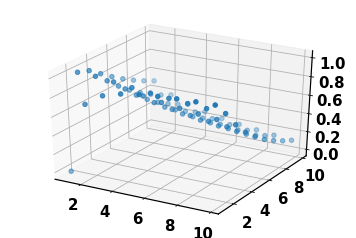

In [46]:
#generate X,T,A for training

x1_train = generateX().reshape(-1,1)
x2_train = generateX().reshape(-1,1)
ntraining = len(x1_train)
t1_train = getT(x1_train, 1).reshape(-1,1)
t2_train = getT(x2_train, 2).reshape(-1,1)

# X, Y, Z = axes3d.get_test_data(0.05)
t1_r_train = np.repeat(t1_train, ntraining, axis=1)
t2_r_train = np.repeat(t2_train, ntraining, axis=1).T

x1_r_train = np.repeat(x1_train, ntraining, axis=1)
x2_r_train = np.repeat(x2_train, ntraining, axis=1).T

a_train = getA(t1_r_train, t2_r_train)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x[:,0:1],x[:,1:2], a_train)
ax.scatter(x1_r_train,x2_r_train, a_train)
plt.show()

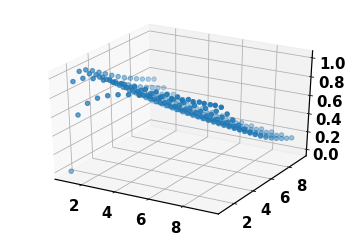

In [47]:
#generate X,T,A for training
# ntesting = 20
x1_test = generateX(nsamples=0.6).reshape(-1,1)
x2_test = generateX(nsamples=0.6).reshape(-1,1)
ntesting = len(x1_test)

t1_test = getT(x1_test, 1).reshape(-1,1)
t2_test = getT(x2_test, 2).reshape(-1,1)

t1_r_test = np.repeat(t1_test, ntesting, axis=1)
t2_r_test = np.repeat(t2_test, ntesting, axis=1).T

x1_r_test = np.repeat(x1_test, ntesting, axis=1)
x2_r_test = np.repeat(x2_test, ntesting, axis=1).T

a_test = getA(t1_r_test, t2_r_test)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1_r_test,x2_r_test, a_test)
plt.show()

In [48]:
# v = a_train.shape
a_train_norm,a_train_sc = normalize(a_train.reshape(-1,1))

x1_train_norm,x1_train_sc = normalize(x1_train)
x2_train_norm,x2_train_sc = normalize(x2_train)
t1_train_norm,t1_train_sc = normalize(t1_train)
t2_train_norm,t2_train_sc = normalize(t2_train)

t1_r_train_norm = np.repeat(t1_train_norm, ntraining, axis=1)
t2_r_train_norm = np.repeat(t2_train_norm, ntraining, axis=1).T
layer2GPinput = np.hstack((t1_r_train_norm.reshape(-1,1),t2_r_train_norm.reshape(-1,1)))

stackedNetwork = StackedGPNetwork(2)
stackedNetwork.createNewNode(1,layer2GPinput,a_train_norm.reshape(-1,1), normalize=True, useGPU=False)
stackedNetwork.createNewNode(0,x1_train_norm,t1_train_norm, normalize=True, useGPU=False)
stackedNetwork.createNewNode(0,x2_train_norm,t2_train_norm, normalize=True, useGPU=False)

In [49]:
stackedNetwork.optimize(numoptimizationtrails=5)

Optimization restart 1/5, f = 0.966250297897
Optimization restart 2/5, f = 0.966250297982
Optimization restart 3/5, f = 0.9662502979
Optimization restart 4/5, f = 0.966250297989
Optimization restart 5/5, f = 0.966250297905
Optimization restart 1/5, f = 0.966250297932
Optimization restart 2/5, f = 0.966250297939
Optimization restart 3/5, f = 0.966250297898
Optimization restart 4/5, f = 0.966250297952
Optimization restart 5/5, f = 0.96625029793
Optimization restart 1/5, f = -267.071886153
Optimization restart 2/5, f = -267.071887205
Optimization restart 3/5, f = -267.071885714
Optimization restart 4/5, f = -267.071884398
Optimization restart 5/5, f = -267.071884215


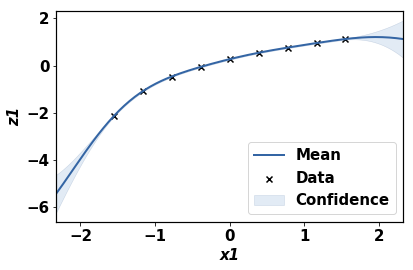

In [50]:
ax = stackedNetwork.getNode(0,0).plot()
ax.set_xlabel('x1',fontweight='bold',fontstyle='italic')
ax.set_ylabel('z1',fontweight='bold',fontstyle='italic')
plt.savefig('../img/exm2x1z1.png', bbox_inches='tight', pad_inches=0.2, rasterized=True,dpi=300)

GP1 mean training data....


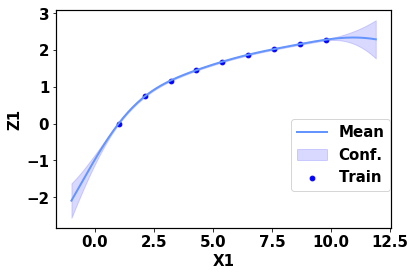

In [51]:
print 'GP1 mean training data....'

x_rang_test = np.arange(-1,12,0.1).reshape(-1,1)
x1_test_norm =x1_train_sc.transform(x_rang_test)
g1_mean_test, g1_var_test = stackedNetwork.getNode(0,0).predict(x1_test_norm)
anlyt_mean_test2 = t1_train_sc.inverse_transform(g1_mean_test.reshape(-1,1)).reshape(-1,1)
std2 = t1_train_sc.scale_[0]*np.sqrt(g1_var_test).ravel()
var_test2 = std2**2

sort_indexs = np.argsort(x_rang_test.reshape(-1))
std = np.sqrt(var_test2[sort_indexs]).ravel()
# xx = x1_test_norm[sort_indexs].ravel()
xx = x_rang_test[sort_indexs].ravel()
pred_sort_mean = anlyt_mean_test2[sort_indexs].ravel()
ymax = 2*std+pred_sort_mean.ravel()
ymin = -2*std+pred_sort_mean.ravel()
plt.plot(xx, pred_sort_mean, c='#6495FF',label='Mean')
plt.fill_between(xx, ymax, ymin, alpha=0.15,color='b',edgecolor='k', linewidth=1,label="Conf.")
plt.xlabel('X1',fontsize=FONT_SIZE, fontweight='bold')
plt.ylabel("Z1",fontsize=FONT_SIZE, fontweight='bold')
plt.scatter(x1_train, t1_train, c='b', s=90, marker='.', label='Train')
plt.legend(bbox_to_anchor=(0.7, 0.5), loc=2, borderaxespad=0.,fontsize=FONT_SIZE)
plt.savefig("../img/em3_gp1_mean.png",bbox_inches='tight', 
               transparent=True,
               pad_inches=0.05)

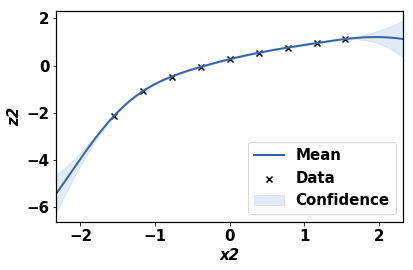

In [52]:
ax = stackedNetwork.getNode(0,1).plot()
ax.set_xlabel('x2',fontweight='bold',fontstyle='italic')
ax.set_ylabel('z2',fontweight='bold',fontstyle='italic')
plt.savefig('../img/exm2x2z2.png', bbox_inches='tight', pad_inches=0.2, rasterized=True,dpi=300)

GP2 mean training data....


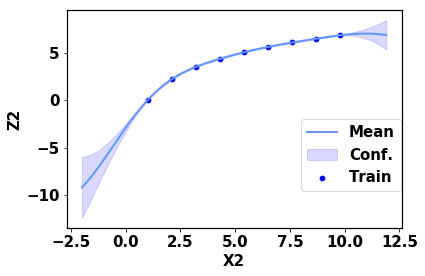

In [53]:
print 'GP2 mean training data....'

x_rang_test = np.arange(-2,12,0.1).reshape(-1,1)
x2_test_norm =x2_train_sc.transform(x_rang_test)
g2_mean_test, g2_var_test = stackedNetwork.getNode(0,1).predict(x2_test_norm)
anlyt_mean_test2 = t2_train_sc.inverse_transform(g2_mean_test.reshape(-1,1)).reshape(-1,1)
std2 = t2_train_sc.scale_[0]*np.sqrt(g2_var_test).ravel()
var_test2 = std2**2

sort_indexs = np.argsort(x_rang_test.reshape(-1))
std = np.sqrt(var_test2[sort_indexs]).ravel()
# xx = x1_test_norm[sort_indexs].ravel()
xx = x_rang_test[sort_indexs].ravel()
pred_sort_mean = anlyt_mean_test2[sort_indexs].ravel()
ymax = 2*std+pred_sort_mean.ravel()
ymin = -2*std+pred_sort_mean.ravel()
plt.plot(xx, pred_sort_mean, c='#6495FF',label='Mean')
plt.fill_between(xx, ymax, ymin, alpha=0.15,color='b',edgecolor='k', linewidth=1,label="Conf.")
plt.xlabel('X2',fontsize=FONT_SIZE, fontweight='bold')
plt.ylabel("Z2",fontsize=FONT_SIZE, fontweight='bold')
plt.scatter(x2_train, t2_train, c='b', s=90, marker='.', label='Train')
plt.legend(bbox_to_anchor=(0.7, 0.5), loc=2, borderaxespad=0.,fontsize=FONT_SIZE)
plt.savefig("../img/em3_gp2_mean.png",bbox_inches='tight', 
               transparent=True,
               pad_inches=0.05)

In [54]:
ax = stackedNetwork.getNode(1,0).plot()
ax.set_xlabel('z1',fontweight='bold',fontstyle='italic')
ax.set_ylabel('z2',fontweight='bold',fontstyle='italic')
plt.savefig('../img/exm2yz1z2.png', bbox_inches='tight', pad_inches=0.2, rasterized=True,dpi=300)

In [71]:
print 'GP3 mean training data....'

t1_rang_test = np.arange(-2.5,1,0.1).reshape(-1,1)
t2_rang_test = np.arange(-6.5,1,0.1).reshape(-1,1)

t1,t2 = np.meshgrid(t1_rang_test,t2_rang_test)

t1_test_norm =t1_train_sc.transform(t1).reshape(-1,1)
t2_test_norm =t2_train_sc.transform(t2).reshape(-1,1)

t_d = np.concatenate((t1_test_norm,t2_test_norm), axis=1)
g2_mean_test, g2_var_test = stackedNetwork.getNode(1,0).predict(t_d)
anlyt_mean_test2 = a_train_sc.inverse_transform(g2_mean_test.reshape(-1,1)).reshape(t1.shape)
std2 = a_train_sc.scale_[0]*np.sqrt(g2_var_test).ravel()
var_test2 = std2**2

plt.figure()
levels = np.arange(-20,20,1)
CS = plt.contour(t1, t2, anlyt_mean_test2,cmap=plt.cm.hot,levels=levels)
colors = plt.cm.hot(np.linspace(0, 1, len(a_train.ravel())))
plt.scatter(t1_r_train.ravel(),t2_r_train.ravel(),color=colors)
cl = plt.clabel(CS, fontsize=10,inline=False)
# for label in cl:
#     label.remove()
# plt.title('Simplest default with labels')




GP3 mean training data....


In [11]:
# print 'Testing Analytical approach on training samples....'
# x1_r_train_norm = np.repeat(x1_train_norm, ntraining, axis=1)
# x2_r_train_norm = np.repeat(x2_train_norm, ntraining, axis=1).T

# traininginput = np.concatenate((x1_r_train_norm.reshape(-1,1), x2_r_train_norm.reshape(-1,1)), axis=1)
# # traininginput = linputsc.transform(traininginput)

# anlyt_mean_train, var = stackedNetwork.predict(traininginput, covoption=1, jitter=0)
# anlyt_mean_train = anlyt_mean_train[-1]
# var = var[-1]

# anlyt_mean_train2 = a_train_sc.inverse_transform(anlyt_mean_train.reshape(-1,1)).reshape(-1,ntraining)

# anlyt_train_err, anlyt_train_rms = ToyUtil.getRMS(a_train, anlyt_mean_train2)
# print 'anlyt_train_RMS = ', anlyt_train_rms

# # ToyUtil.plottingScatter3D(x1_r_train,'x1_train',x2_r_train,'x2_train', a_train,'Actual_Data_train', anlyt_mean_train2,
# #                        'Predicting_Analytical_mean', savefname='syn_train_2.eps')

In [12]:
print 'Testing Analytical approach on testing samples....'

x1_test_norm =x1_train_sc.transform(x1_test)
x2_test_norm = x2_train_sc.transform(x2_test)

x1_r_test_norm = np.repeat(x1_test_norm, ntesting, axis=1)
x2_r_test_norm = np.repeat(x2_test_norm, ntesting, axis=1).T

testinginput = np.concatenate((x1_r_test_norm.reshape(-1,1), x2_r_test_norm.reshape(-1,1)), axis=1)

anlyt_mean_test, var_test = stackedNetwork.predict(testinginput, covoption=2, jitter=1e-8)
anlyt_mean_test = anlyt_mean_test[-1]
var_test = var_test[-1]

anlyt_mean_test2 = a_train_sc.inverse_transform(anlyt_mean_test.reshape(-1,1)).reshape(-1,ntesting)

var_test2 = a_train_sc.inverse_transform(var_test.reshape(-1,1)).reshape(-1,ntesting)

anlyt_test_err2, anlyt_test_rms2 = ToyUtil.getRMS(a_test, anlyt_mean_test2)

# ToyUtil.plottingScatter3D(x1_r_test,'x1_test',x2_r_test,'x2_test', a_test,'Actual_Data_test', anlyt_mean_test2,
#                        'Predicting_Analytical_mean', savefname='syn_test_2.eps')
print 'anlyt_test_RMS2 = ', anlyt_test_rms2
print 'AvgRatio = ', np.array(abs(a_test-anlyt_mean_test2)/np.sqrt(var_test2).reshape(a_test.shape)).mean()


Testing Analytical approach on testing samples....
anlyt_test_RMS2 =  0.0224592550577
AvgRatio =  0.00268933700504


 /usr/local/lib/python2.7/site-packages/matplotlib/artist.py:798: UserWarning:Rasterization of 'Axes(0.125,0.125;0.775x0.755)' will be ignored


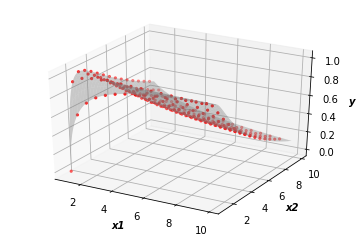

In [13]:
def fun(x, y):
    t1 = np.log(x)
    t2 = np.log(y**3)
    return np.sin(np.sqrt(np.add(t1,t2)))

fig = plt.figure()
fig.set_rasterized(True)
ax = fig.add_subplot(111, projection='3d')
x = y = np.arange(1, 10, 0.1)
X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)

surface = ax.plot_surface(X, Y, Z,color='gray', shade=False, linewidth=0,alpha=0.4)
# clrs = colors.to_rgb('gray')
# surface.set_facecolor('gray')
# surface.set_alpha(0.5)
ax.set_xlabel('x1',fontweight='bold',fontstyle='italic')
ax.set_ylabel('x2',fontweight='bold',fontstyle='italic')
ax.set_zlabel('y',fontweight='bold',fontstyle='italic')

# ax.scatter(x1_r_train,x2_r_train, a_train, marker='.', c='b', s=50)
ax.scatter(x1_r_test,x2_r_test, a_test, marker='.', c='r')
ax.set_rasterized(True)
ax.set_rasterization_zorder(0)

plt.show()

fig.savefig('../img/syn_surface_2.eps', bbox_inches='tight', pad_inches=0.2, rasterized=True,dpi=300)




In [64]:
def predictStacked(x1,x2):
    print ".",#x1.shape
    x1_test_norm =x1_train_sc.transform(x1)
    x2_test_norm = x2_train_sc.transform(x2)

    x1_r_test_norm = np.repeat(x1_test_norm, x1_test_norm.shape[0], axis=1)
    x2_r_test_norm = np.repeat(x2_test_norm, x1_test_norm.shape[0], axis=1).T
#     print x1_r_test_norm.shape
    testinginput = np.concatenate((x1_r_test_norm.reshape(-1,1), x2_r_test_norm.reshape(-1,1)), axis=1)

    anlyt_mean_test, var_test = stackedNetwork.predict(testinginput, covoption=2, jitter=1e-6)
    anlyt_mean_test = anlyt_mean_test[-1]
    var_test = var_test[-1]

    anlyt_mean_test2 = a_train_sc.inverse_transform(anlyt_mean_test.reshape(-1,1)).reshape(-1,x1_test_norm.shape[0])

#     var_test2 = a_train_sc.inverse_transform(var_test.reshape(-1,1)).reshape(-1,x1_test_norm.shape[0])
    std_test2 = np.sqrt(var_test.reshape(-1,1)).reshape(-1,x1_test_norm.shape[0])*a_train_sc.scale_

    
    return anlyt_mean_test2, std_test2


def fun(x, y):
    t1 = np.log(x)
    t2 = np.log(y**3)
    return np.sin(np.sqrt(np.add(t1,t2)))

def draw_surface(xst,xend,yst,yend):
#     x = np.arange(xst, xend, 0.3)
#     y = np.arange(yst, yend, 0.3)
    maxlimt = 20
    x = np.linspace(xst, xend, maxlimt)
    y = np.linspace(yst, yend, maxlimt)
    X, Y = np.meshgrid(x, y)
    X = X.T
    Y = Y.T
    # print X.shape
    # zs = np.array([predictStacked(np.array([x]).reshape(1,1),np.array([y]).reshape(1,1))[0] for x,y in zip(np.ravel(X), np.ravel(Y))])
    zs,zstd = predictStacked(x.reshape(-1,1), y.reshape(-1,1))
#     zs2 = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])

    Z2 = zs.reshape(X.shape)
    surface = ax.plot_surface(X, Y, Z2,color='yellow', shade=False, linewidth=0,alpha=0.25,label="mean")
    
#     Z2 = zs2.reshape(X.shape)
#     surface = ax.plot_surface(X, Y, Z2,color='yellow', shade=False, linewidth=0,alpha=0.25,label="true surface")

    lower = zs-2*zstd
    Z = (lower).reshape(X.shape)
    surface = ax.plot_surface(X, Y, Z,color='gray', shade=False, linewidth=0,alpha=0.3,label="lower bound")

    upper = zs+2*zstd
    Z = (upper).reshape(X.shape)
    surface = ax.plot_surface(X, Y, Z,color='gray', shade=False, linewidth=0,alpha=0.3,label="upper bound")


fig = plt.figure()
fig.set_rasterized(True)
ax = fig.add_subplot(111, projection='3d')
val = 10
draw_surface(1,val,1,val)
# draw_surface(-val,0,-val,0)
# draw_surface(0,val,-val,0)
# draw_surface(-val,0,0,val)

# clrs = colors.to_rgb('gray')
# surface.set_facecolor('gray')
# surface.set_alpha(0.5)
ax.set_xlabel('x1',fontweight='bold',fontstyle='italic')
ax.set_ylabel('x2',fontweight='bold',fontstyle='italic')
ax.set_zlabel('y',fontweight='bold',fontstyle='italic')

# ax.scatter(x1_r_train,x2_r_train, a_train, marker='.', c='b', s=50)
anlyt_mean_test2, zstd = predictStacked(x1_test,x2_test)

pplus = np.abs(a_test -anlyt_mean_test2) > 2*zstd
ax.scatter(x1_r_test[pplus],x2_r_test[pplus], a_test[pplus], marker='.', c='r')

po =  abs(a_test -anlyt_mean_test2) <= 2*zstd
ax.scatter(x1_r_test[po],x2_r_test[po], a_test[po], marker='+', c='b')
# plt.legend(bbox_to_anchor=(0.47, 0.98), loc=2, borderaxespad=0.)


ax.set_rasterized(True)
ax.set_rasterization_zorder(0)
plt.show()

fig.savefig('../img/ss2_ard_false.eps', bbox_inches='tight', pad_inches=0.2, rasterized=True,dpi=300)

. .

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

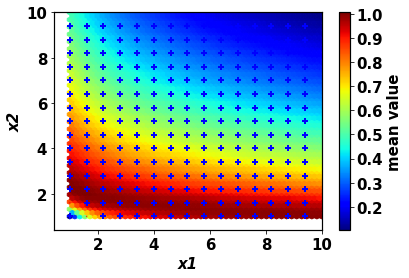

In [65]:
# def draw_surface(xst,xend,yst,yend):
def draw_surface(x,y,fx,fy,fz,fstd):
    X, Y = np.meshgrid(x, y)
    zs,zstd = predictStacked(x.reshape(-1,1), y.reshape(-1,1))
    Z2 = zs.reshape(X.shape)
    z = Z2.ravel()
    fx = fx+ list(X.T.ravel())
    fy = fy + list(Y.T.ravel())
    fz = fz+list(z)
    fstd = fstd+list(zstd.ravel())
    return fx,fy,fz,fstd
#     plt.axis([x.min(), x.max(), y.min(), y.max()])
    
fig = plt.figure()
fx = []
fy = []
fz = []
fstd = []
ax = fig.add_subplot(111)
maxlimt = 100
x = np.linspace(1,10, maxlimt)
y = np.linspace(1,10, maxlimt)

step = 10
for i in range(0,maxlimt,step):
    for j in range(0,maxlimt,step):
        fx,fy,fz,fstd= draw_surface(x[i:i+step],y[j:j+step],fx,fy,fz,fstd)

plt.hexbin(fx, fy, C=fz, cmap=plt.cm.jet,gridsize=50)

ax.set_xlabel('x1',fontweight='bold',fontstyle='italic')
ax.set_ylabel('x2',fontweight='bold',fontstyle='italic')
cb = plt.colorbar()
cb.set_label('mean value',fontsize=FONT_SIZE, fontweight='bold')

# ax.scatter(x1_r_train,x2_r_train, a_train, marker='.', c='b', s=50)
anlyt_mean_test2, zstd = predictStacked(x1_test,x2_test)

pplus = np.abs(a_test -anlyt_mean_test2) > 2*zstd
ax.scatter(x1_r_test[pplus],x2_r_test[pplus], a_test[pplus], marker='.', c='r')

po =  abs(a_test -anlyt_mean_test2) <= 2*zstd
ax.scatter(x1_r_test[po],x2_r_test[po], marker='+', c='b') # a_test[po],
# plt.legend(bbox_to_anchor=(0.47, 0.98), loc=2, borderaxespad=0.)

title_label="exm2_heatmap"
plt.savefig(title_label+".png",bbox_inches='tight',transparent=True,
               pad_inches=0.05)
plt.show()

# fig.savefig('../img/ss3_ard_false.eps', bbox_inches='tight', pad_inches=0.2, rasterized=True,dpi=300)

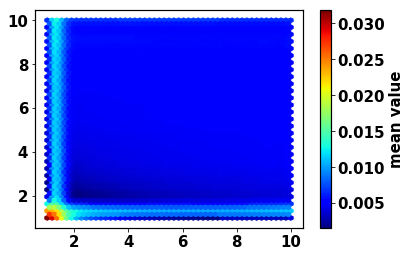

In [67]:
plt.hexbin(fx, fy, C=fstd, cmap=plt.cm.jet,gridsize=50)

ax.set_xlabel('x1',fontweight='bold',fontstyle='italic')
ax.set_ylabel('x2',fontweight='bold',fontstyle='italic')
cb = plt.colorbar()
cb.set_label('mean value',fontsize=FONT_SIZE, fontweight='bold')
title_label="exm2_heatmap_std"
plt.savefig(title_label+".png",bbox_inches='tight',transparent=True,
               pad_inches=0.05)
plt.show()